# ZILLOW CHALLANGE

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt

/Users/Cemal/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data and View the labels

In [2]:
print('Loading data ...')

train = pd.read_csv('./input/train_2016_v2.csv')
prop = pd.read_csv('./input/properties_2016.csv')
sample = pd.read_csv('./input/sample_submission.csv')


Loading data ...


/Users/Cemal/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Checking the Data

In [3]:
print(prop.columns)

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

In [4]:
print(prop.head(1).transpose())

                                        0
parcelid                         10754147
airconditioningtypeid                 NaN
architecturalstyletypeid              NaN
basementsqft                          NaN
bathroomcnt                             0
bedroomcnt                              0
buildingclasstypeid                   NaN
buildingqualitytypeid                 NaN
calculatedbathnbr                     NaN
decktypeid                            NaN
finishedfloor1squarefeet              NaN
calculatedfinishedsquarefeet          NaN
finishedsquarefeet12                  NaN
finishedsquarefeet13                  NaN
finishedsquarefeet15                  NaN
finishedsquarefeet50                  NaN
finishedsquarefeet6                   NaN
fips                                 6037
fireplacecnt                          NaN
fullbathcnt                           NaN
garagecarcnt                          NaN
garagetotalsqft                       NaN
hashottuborspa                    

/Users/Cemal/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


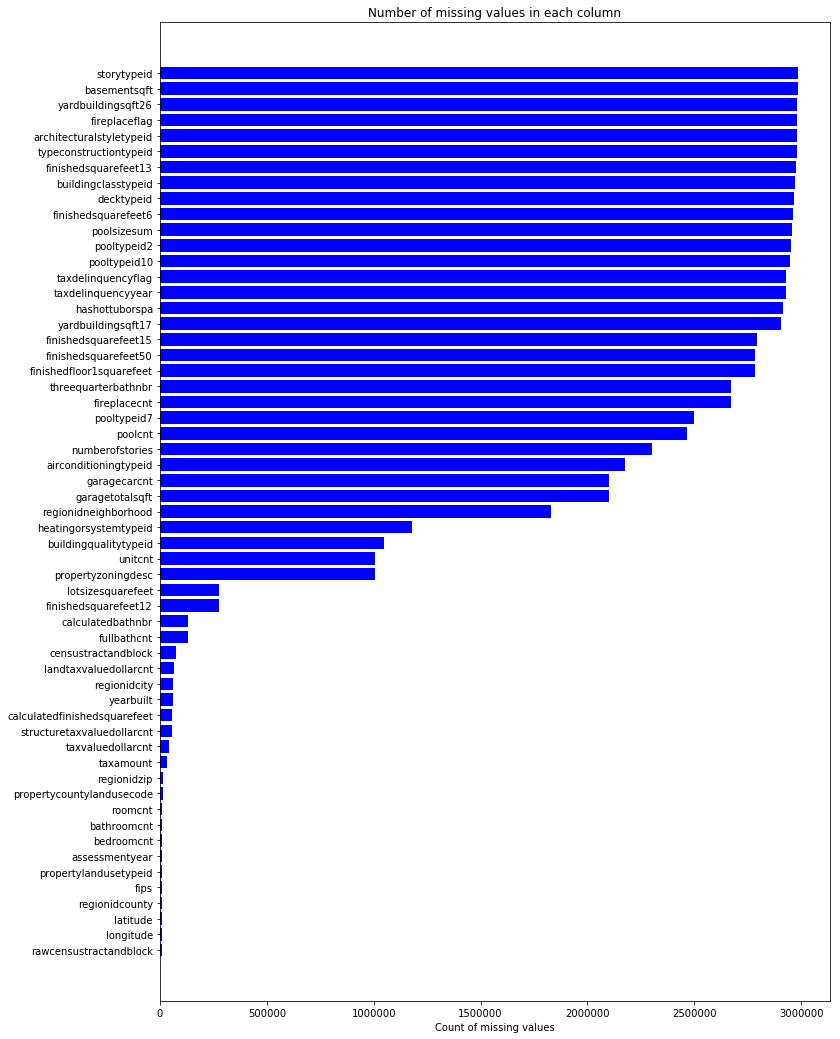

In [5]:
missing_df = prop.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

## Changing Variable Types

In [6]:
print('Binding to float32')

for c, dtype in zip(prop.columns, prop.dtypes):
	if dtype == np.float64:
		prop[c] = prop[c].astype(np.float32)

Binding to float32


## Create the Training and Validation Set

In [7]:
print('Creating training set ...')

df_train = train.merge(prop, how='left', on='parcelid')

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values
print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)


split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

Creating training set ...
(90275, 55) (90275,)


## Build DMatrix

In [8]:
print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)



Building DMatrix...


## Train the Model

In [9]:
print('Training ...')

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

#del d_train, d_valid

Training ...
[0]	train-mae:0.488065	valid-mae:0.48112
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.402221	valid-mae:0.395444
[20]	train-mae:0.33268	valid-mae:0.326099
[30]	train-mae:0.276518	valid-mae:0.270132
[40]	train-mae:0.231316	valid-mae:0.225213
[50]	train-mae:0.195059	valid-mae:0.189317
[60]	train-mae:0.166121	valid-mae:0.16072
[70]	train-mae:0.143116	valid-mae:0.138042
[80]	train-mae:0.124973	valid-mae:0.120214
[90]	train-mae:0.11079	valid-mae:0.106351
[100]	train-mae:0.099822	valid-mae:0.095702
[110]	train-mae:0.091454	valid-mae:0.087592
[120]	train-mae:0.085149	valid-mae:0.08158
[130]	train-mae:0.080457	valid-mae:0.077192
[140]	train-mae:0.077015	valid-mae:0.074063
[150]	train-mae:0.07451	valid-mae:0.071827
[160]	train-mae:0.072688	valid-mae:0.070245
[170]	train-mae:0.071374	valid-mae:0.069128
[180]	train-mae:0.070415	valid-mae:0.068366
[190]	train-mae:0.069715

## Build the Test Set

In [10]:
print('Building test set ...')

sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')



x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)


d_test = xgb.DMatrix(x_test)

Building test set ...


/Users/Cemal/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Predict the test

In [11]:
print('Predicting on test ...')

p_test = clf.predict(d_test)

Predicting on test ...


## Print the Final File

In [12]:
sub = pd.read_csv('./input/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

print('Writing csv ...')
sub.to_csv('xgb_zillow.csv', index=False, float_format='%.4f') 

Writing csv ...
